In practice it's very uncommon to work with datasets that are 2 or 3 dimensional, and so can be plotted directly. We're now going to look at _dimensionality reduction_ : a category of unsupervised algorithms which attempt to collapse high-dimensional datasets into a low-dimensional space.

As suggested above, one reason to do this is to aid visualization. However, that's far from the only reason dimensionality reduction is useful! These techniques also allow us to filter noise, extract useful features, and accomplish much more.

Let's dive into PCA with the Iris dataset.

### PCA - Overview

1. Standardize the data.


2. Obtain the Eigenvectors and Eigenvalues from the Covariance matrix (or Correlation matrix), or perform Singular Vector Decomposition.


3. Sort eigenvalues in descending order and choose the 𝑘 eigenvectors that correspond to the 𝑘 largest eigenvalues where 𝑘 is the number of dimensions of the new feature subspace. 𝑘 is less than original dimensionality.


4. Construct the projection matrix 𝐖 from the selected 𝑘 eigenvectors.


5. Transform the original dataset 𝐗 via 𝐖 to obtain a 𝑘-dimensional feature subspace 𝐘.

### Time series data

The dataset is of Tuberculosis prevalence over various countries between the given time period.

Data url: 'https://raw.githubusercontent.com/aps1070-2019/datasets/master/tb-data.csv'.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/aps1070-2019/datasets/master/tb-data.csv', sep=',')

In [0]:
data = data.rename(columns={'TB prevalence, all forms (per 100 000 population per year)': 'TBprevalence'})

In [0]:
# n, d
data.shape

(207, 19)

In [0]:
cols = data.columns

In [0]:
date = cols[1:]

In [0]:
# all the values in the dateset are strings
data.iloc[1,1]

'42'

In [0]:
# remove commas
data[cols] = data[cols].replace(',','', regex=True)

In [0]:
# then change to int
data.iloc[:, 1:] = data.iloc[:, 1:].astype('int32')

In [0]:
data.head()

,TBprevalence,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
0,Afghanistan,436,429,422,415,407,397,397,387,374,373,346,326,304,308,283,267,251,238
1,Albania,42,40,41,42,42,43,42,44,43,42,40,34,32,32,29,29,26,22
2,Algeria,45,44,44,43,43,42,43,44,45,46,48,49,50,51,52,53,55,56
3,American Samoa,42,14,4,18,17,22,0,25,12,8,8,6,5,6,9,11,9,5
4,Andorra,39,37,35,33,32,30,28,23,24,22,20,20,21,18,19,18,17,19


### Standardizing Data

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. 

Although, all features in the dataset were measured in population, we should continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.

In [0]:
X = data.iloc[:,1:].values
y = data.iloc[:,0].values
X_std = StandardScaler().fit_transform(X) # 207x18
n, m = X_std.shape # n=207 m=18
C = np.dot(X_std.T, X_std)/(n-1) # 18x18

### Eigendecomposition - Computing Eigenvectors and Eigenvalues

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

Methods to perform PCA:

1. The classic approach to PCA is to perform the eigendecomposition on the covariance matrix Σ, which is a 𝑑×𝑑 matrix where each element represents the covariance between two features.

2. But, most PCA implementations perform a Singular Vector Decomposition (SVD) to improve the computational efficiency.

In [0]:
# Here I use covariance matrix
eigenValues, eigenVectors = np.linalg.eig(C)

### Sort based on eigenValues

In [0]:
args = (-eigenValues).argsort()
eigenValues = eigenValues[args]
eigenVectors = eigenVectors[:, args]

### Plot the first 6 principle components

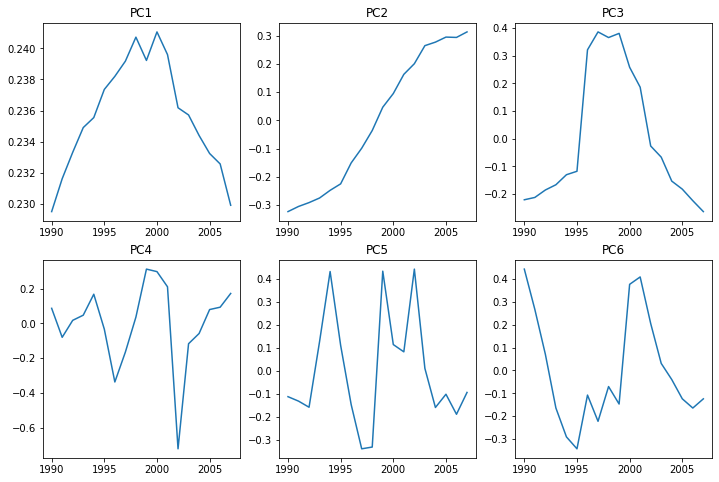

In [0]:
count = 6
W = eigenVectors[:, 0:count] # 18x6
num = 6
ROWS = math.ceil(num/3)
fig = plt.figure(figsize=(12 , ROWS * 4))
for i in range(0, num):
    plt.subplot(ROWS, 3, i+1)
    plt.plot(date, W[:,i])
    plt.xticks(date[::5])
    plt.title('PC{}'.format(i+1))

We can see the first PC is very important, it shows the TB prevelance trend is mainly increasing first and then decreasing, the second PC shows another trend in some countries, which is consistently increasing. Other PCs are kinda of noisy, they cannot capture much useful information.

### Select one country for a close look

In [0]:
Japan = data[data.iloc[:,0]=='Japan']

In [0]:
Japan = Japan.iloc[0, 1:]

Text(0, 0.5, 'TB prevelance')

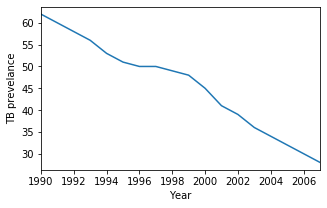

In [0]:
fig = plt.figure(figsize=(5 , 3))
Japan.plot(kind='line')
plt.xlabel('Year')
plt.ylabel('TB prevelance')

In [0]:
# compute the mean in each column/year/feature in original dataset
mu = data.iloc[:, 1:].mean(axis=0)
std = data.iloc[:, 1:].std(axis=0)

#### Use eigenvalues above to reconstruct data and see performance

In [0]:
def project(W , X , mu, std):
    return np.dot((X - mu)/std , W)
def reconstruct(W , Y , mu, std):
    return np.dot(Y , W.T)*std + mu

In [0]:
count = 6
recons = []
for numEvs in range (1, count+1):
    P = project(eigenVectors[:, 0:numEvs], Japan, mu, std) # projection = 1x6
    R = reconstruct(eigenVectors[:, 0:numEvs], P, mu, std) # reconstruction = 1x18
    recons.append(R)

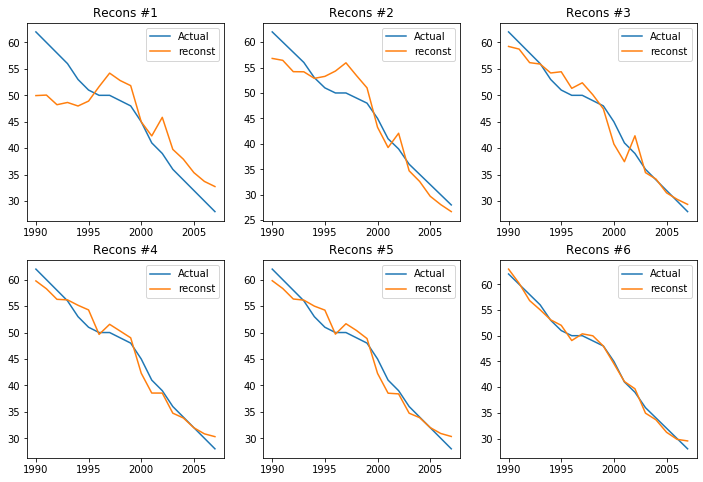

In [0]:
# plot reconstructed data
ROWS = math.ceil(count/3)
fig = plt.figure(figsize=(12, ROWS * 4))
for i in range(0, count):
    plt.subplot(ROWS, 3, i+1)
    plt.plot(Japan, label = 'Actual')
    plt.plot(recons[i], label = 'reconst')
    plt.xticks(date[::5])
    plt.legend()
    plt.title('Recons #{}'.format(i+1))

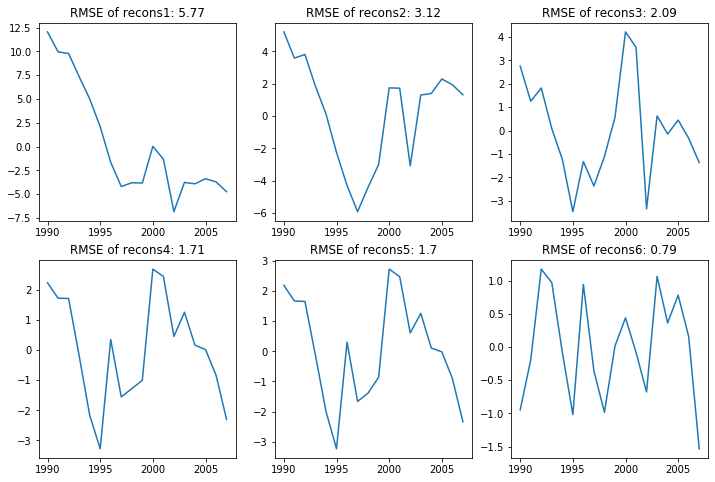

In [0]:
# plot RMSE for each construction
count = 6
ROWS = math.ceil(count/3)
fig = plt.figure(figsize=(12, ROWS * 4))
for i in range(0, count):
    plt.subplot(ROWS, 3, i+1)
    residuals = Japan-recons[i]
    RMSE = np.sqrt(sum(residuals**2)/len(residuals))
    plt.plot(residuals)
    plt.xticks(date[::5])
    plt.title('RMSE of recons{}: {}'.format(i+1, round(RMSE, 2)))

### Explained Variance

In [0]:
# this function can check how many PCs need to reach a variance threshold
def getBasisCountThatPreservesVariance(eigenValues, variance=0.99):
    for idx, cumulativeSum in enumerate(np.cumsum(eigenValues)/np.sum(eigenValues)):
        if cumulativeSum > variance:
            return idx+1

In [0]:
getBasisCountThatPreservesVariance(eigenValues, variance=0.99)

4

We can see the variance captured by the first 4 PCs are over 99%, and also from last question we can see the RMSE is stable and small since PC4, so 4 PCs are enough to describe the pattern of the dateset.

In [0]:
eigValSum = sum(eigenValues)
expVar = [eigV/eigValSum*100 for eigV in eigenValues]
cumExpVar = np.cumsum(expVar)
cumExpVar

array([ 92.03977111,  97.74467407,  98.90913378,  99.16258184,
        99.39246981,  99.55243536,  99.6751039 ,  99.7639778 ,
        99.82947975,  99.87721587,  99.91009571,  99.93752202,
        99.96140791,  99.97587443,  99.98672718,  99.99368582,
        99.99782377, 100.        ])

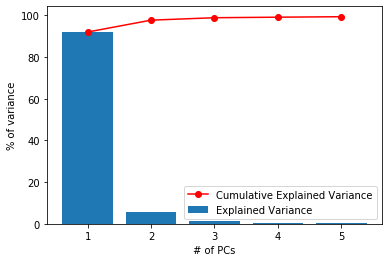

In [0]:
plt.bar(np.arange(1, 6), expVar[:5], label='Explained Variance')
plt.plot(np.arange(1, 6), cumExpVar[:5], 'r-o', label='Cumulative Explained Variance')
plt.xlabel('# of PCs')
plt.ylabel('% of variance')
plt.legend()
plt.show()